In [354]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# TODO
- implement a full component index for model output! (maybe later though, make sure to have all dimensions indexed, is all)
- is odeint usage possible? by passing run_step as function (any_object?), instead passing array values?
- implement external initialisations for Components, like Allometric Phytoplankton


# NOTES:
### 1. intent is very important! needs to have a proper routing!

In [507]:
# This definitely also makes sense, but just as construction help for future components (and building block of the current ones)
@xs.process
class Time:
    days = xs.variable(dims='time', description='time in days')
    # for indexing xarray IO objects
    # NOTE: this is what allows storing the output along time properly even when using odeint!
    time = xs.index(dims='time', description='time in days')
    
    def initialize(self):
        self.time = self.days
        self.internal_time = 0
    
    @xs.runtime(args="step_delta")
    def run_step(self, dt):
        self.internal_time += dt 
        
@xs.process
class Component:
    """Base class encoding behaviour for a component of a ecosystem.
        subclass needs to have implemented:
        self.num, self.component_label, self.init, 
        
    """
    num = xs.variable(dims=(),intent='in')
    delta = xs.variable(intent='out')
    
    
    def run_step(self):
        # Note to self: sum yields1D array, due to generator unpacking within sum
        self.delta = sum((v for v in self.fluxes)) #maybe can remove forcing to numpy array here later
    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        print(self.label, self.state, self.delta, dt)
        self.state = self.state + self.delta * dt * self.state
        print(self.label, self.state, self.delta, dt)


        
@xs.process
class Nutrient:
    """"""
    num = xs.variable(dims=(),intent='in')
    
    N = xs.index(dims='N')
    component_label = xs.variable(default='N', groups='component-label', static=True)
    
    delta = xs.variable(dims='N', intent='out')
    
    fluxes = xs.group('n_flux')
    state = xs.variable(dims='N', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})

    # PARAMETERS / INPUTS
    num = xs.variable(default=1, static=True, description='number of nutrients (1 by default)')
    init = xs.variable(dims='N', intent='in')
    
    def initialize(self):
        self.N = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.state = self.init
        
    def run_step(self):
        # Note to self: sum yields1D array, due to generator unpacking within sum
        self.delta = sum((v for v in self.fluxes)) #maybe can remove forcing to numpy array here later
    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        print(self.state, self.delta, dt)
        self.state = self.state + self.delta * dt * self.state
        print(self.state, self.delta, dt)
            
@xs.process
class Phytoplankton:
    num = xs.variable(dims=(),intent='in')
    """"""
    P = xs.index(dims='P')
    component_label = xs.variable(default='P', groups='component-label', static=True)
    
    delta = xs.variable(dims='P', intent='out')
        
    fluxes = xs.group('p_flux')
    state = xs.variable(dims='P', intent='inout', groups = 'state-variables', description='component array', attrs={'units': 'µM N'})
    
    # PARAMETERS / INPUTS
    init = xs.variable(dims='P',intent='in')
    halfsat = xs.variable(intent='in', dims='P', groups='parameters')
    
    def initialize(self):
        self.P = np.array([f"{self.component_label}-{i+1}" for i in range(self.num)])
        self.state = self.init
    
    def run_step(self):
        # Note to self: sum yields1D array, due to generator unpacking within sum
        self.delta = sum((v for v in self.fluxes)) #maybe can remove forcing to numpy array here later
    
    @xs.runtime(args="step_delta")
    def finalize_step(self, dt):
        print(self.state, self.delta, dt)
        self.state = self.state + self.delta * dt * self.state
        print(self.state, self.delta, dt)

@xs.process
class ChemostatSetup:
    P_num = xs.variable(intent='in', static=True, description='number of Phytoplankton')
    P_initVal = xs.variable(intent='in', dims=[(), 'P'], static=True, description='initial Phytoplankton biomass')
    halfsat = xs.variable(intent='in', dims=[(), 'P'], static=True, description='half-saturation constant of nutrient uptake for P')

    P_num_out = xs.foreign(Phytoplankton, 'num', intent='out')    
    P_init = xs.foreign(Phytoplankton, 'init', intent='out')
    halfsat_out = xs.foreign(Phytoplankton, 'halfsat', intent='out')
    
    N_initVal = xs.variable(intent='in', static=True, description='initial Nutrient concentration')
    N_init = xs.foreign(Nutrient, 'init', intent='out')

    
    def initialize(self):
        print('init')
        self.P_num_out = self.P_num
        self.halfsat_out = np.array([self.halfsat for i in range(self.P_num)])
        self.P_init = np.array([self.P_initVal for i in range(self.P_num)])
        self.N_init = np.array([self.N_initVal for i in range(1)])
        
        
    
@xs.process
class NutrientUptake:
    """"""
    growth = xs.variable(
        dims='P',
        intent='out',
        groups=['p_flux'],
        description='phytoplankton growth, under light & nutrient limitation'
    )
    
    uptake = xs.variable(
        dims='N',
        intent='out',
        groups=['n_flux'],
        description='sum of all phytoplankton growth'
    )
    
    N = xs.foreign(Nutrient, 'state', intent='out')
    P = xs.foreign(Phytoplankton, 'state', intent='out')
    P_halfsat = xs.foreign(Phytoplankton, 'halfsat', intent='in')
    
    def run_step(self):
        nutrient_uptake = self.N / (self.P_halfsat + self.N)
        self.growth = nutrient_uptake
        self.uptake = - sum(nutrient_uptake)
        #print(self.growth, self.uptake)
    
    
@xs.process
class Forcing:
    """Sum up all forcing processes and their effects, respectively.
    """
    pass
    

class NutrientSource(Forcing):
    """Chemostat constant nutrient inflow from one direction"""
    forcing_flux = xs.variable(
        dims=[(), 'N'],
        intent='out',
        groups='n_flux',
        description='constant nutrient influx'
    )

    #N = xs.foreign(Nutrient, 'state')
    
    #@xs.runtime(args='step_delta')
    def run_step(self):
        self.forcing_flux = np.array(0.1)


In [508]:
mod = xs.Model(
    {
        'ModelSetup':ChemostatSetup,
        'N':Nutrient, 
        'P':Phytoplankton, 
        'N_Uptake':NutrientUptake, 
        'N_source':NutrientSource
    }
)

In [509]:
mod

<xsimlab.Model (5 processes, 7 inputs)>
ModelSetup
    halfsat             [in] () or ('P',) half-saturation constant ...
    P_num               [in] number of Phytoplankton
    P_initVal           [in] () or ('P',) initial Phytoplankton bio...
    N_initVal           [in] initial Nutrient concentration
N_Uptake
N
    component_label     [in]
    num                 [in] number of nutrients (1 by default)
P
    component_label     [in]
N_source

In [510]:
in_ds = xs.create_setup(
     model=mod,
     clocks={
         'time': np.linspace(0., 1., 20)
     },
     master_clock='time',
     input_vars={
         'ModelSetup':{'P_num':5,'P_initVal':1,'halfsat':0.5, 'N_initVal':1}
     },
     output_vars={
        'P__state': 'time',
        'N__state': 'time'
     }
 )

In [511]:
with mod:
    out_ds = in_ds.xsimlab.run()

init
[1] -3.333333333333333 0.05263157894736842
[0.8245614] -3.333333333333333 0.05263157894736842
[1 1 1 1 1] [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667] 0.05263157894736842
[1.03508772 1.03508772 1.03508772 1.03508772 1.03508772] [0.66666667 0.66666667 0.66666667 0.66666667 0.66666667] 0.05263157894736842
[0.8245614] -3.112582781456954 0.05263157894736842
[0.68948163] -3.112582781456954 0.05263157894736842
[1.03508772 1.03508772 1.03508772 1.03508772 1.03508772] [0.62251656 0.62251656 0.62251656 0.62251656 0.62251656] 0.05263157894736842
[1.06900136 1.06900136 1.06900136 1.06900136 1.06900136] [0.62251656 0.62251656 0.62251656 0.62251656 0.62251656] 0.05263157894736842
[0.68948163] -2.8982441349067836 0.05263157894736842
[0.58430868] -2.8982441349067836 0.05263157894736842
[1.06900136 1.06900136 1.06900136 1.06900136 1.06900136] [0.57964883 0.57964883 0.57964883 0.57964883 0.57964883] 0.05263157894736842
[1.10161428 1.10161428 1.10161428 1.10161428 1.10161428] [0.5796488

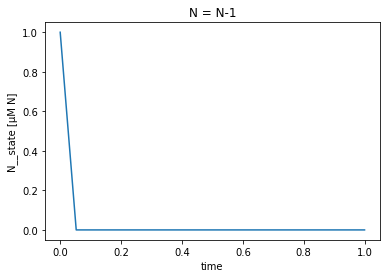

In [512]:
out_ds.N__state.plot()

In [515]:
out_ds.P__state.sel(P='P-1')

<xarray.DataArray 'P__state' (time: 20)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Coordinates:
    P        <U3 'P-1'
  * time     (time) float64 0.0 0.05263 0.1053 0.1579 ... 0.8947 0.9474 1.0
Attributes:
    description:  component array
    units:        µM N
    _FillValue:   0

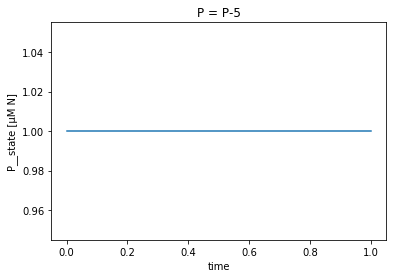

In [516]:
out_ds.P__state.sel(P='P-5').plot()